In [1]:
import datetime
from inspect import getmembers, isfunction

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import gusi_wrf
import gusi_utils


# Rutas y configuraciones

In [2]:
plotdir = '.'

In [3]:
wrf_file = '../datos_WRF/CdCuauhtemoc_WRF.csv'

In [4]:
aem_file = '../datos_AEM/2018-082020/CdCuauhtemoc_AEM.csv'

# Análisis de WRF y AEM

In [5]:
title = 'Cd Cuauhtemoc 2018-2020'

In [6]:
date_bgn = datetime.datetime(2018,1,1,0)
date_end = datetime.datetime(2020,8,31,23)

In [7]:
#Read WRF csv and create dataframe
df_wrf = pd.read_csv(wrf_file,index_col='Date',parse_dates=True)
df_wrf.index = df_wrf.index - pd.DateOffset(hours=6)        #Pasar WRF a hora local
df_wrf = df_wrf.loc[date_bgn : date_end]

In [8]:
#Read AEM
df_aem = pd.read_csv(aem_file,index_col='Date',parse_dates=True)
df_aem = df_aem.resample('1H').mean()
df_aem = df_aem.loc[date_bgn : date_end]

#Join dataframe
df = df_wrf.join(df_aem)
df.rename(columns = {'Wind speed':'WRF-80m','WS_80mA_mean':'AEM-80m','Wind from direction':'WRF-direction','WD_78m_mean':'AEM-direction'}, inplace=True)

df_ws = df[['WRF-80m', 'AEM-80m']]
df_wd = df[['WRF-direction', 'AEM-direction']]

### Series Temporales

Text(0.5, 1.0, 'Cd Cuauhtemoc 2018-2020')

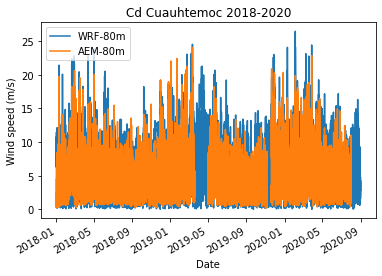

In [9]:
ts = df_ws.plot(ylabel='Wind speed (m/s)')
plt.title(title)
#plt.savefig(plotdir+'/ts_'+title+'.pdf',format='pdf',bbox_inches='tight')
#plt.close(fig)


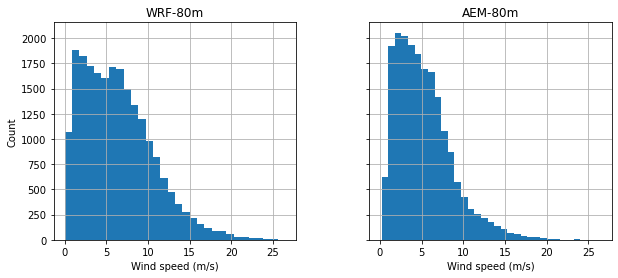

In [10]:
hist = df_ws.hist(bins=30, sharey=True, sharex=True, figsize=(10,4))
for ax in hist.flatten():
    ax.set_xlabel("Wind speed (m/s)")
    ax.set_ylabel("Count")
plt.savefig('hist.pdf',format='pdf',bbox_inches='tight')

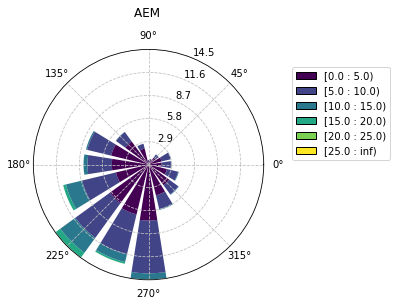

In [11]:
aem_dir = gusi_utils.wind_rose(df_wd['AEM-direction'],df_ws['AEM-80m'],'AEM \n',4,cm.viridis)
plt.savefig('wd_aem.pdf',format='pdf',bbox_inches='tight')

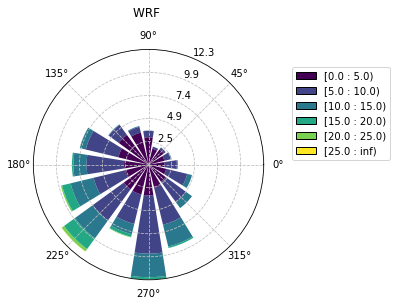

In [12]:
wrf_dir = gusi_utils.wind_rose(df_wd['WRF-direction'],df_ws['WRF-80m'],'WRF \n',4,cm.viridis)
plt.savefig('wd_wrf.pdf',format='pdf',bbox_inches='tight')

### Statistic metrics

In [13]:
from scipy import stats
import sklearn.metrics
import numpy as np

AEM_80m, WRF_80m = gusi_utils.ignore_nan(df_ws['AEM-80m'],df_ws['WRF-80m'])
r = stats.pearsonr(WRF_80m,AEM_80m)[0]
mae = sklearn.metrics.mean_absolute_error(WRF_80m,AEM_80m)
bias = np.sum((WRF_80m-AEM_80m)/len(AEM_80m))
print(r,mae,bias)

0.6671604480020871 2.5062579764079786 1.1001620613511054


/home/jose/miniconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/home/jose/miniconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


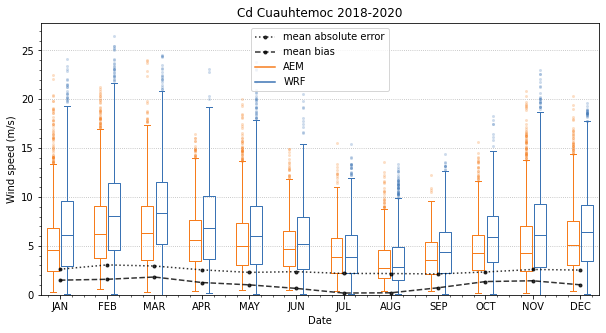

In [14]:
from sklearn.metrics import mean_absolute_error

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)
    plt.setp(bp['fliers'], alpha=0.25, markeredgewidth=0, markersize=3, markerfacecolor=color)

meses_aem = []
for mes in range(1, 13) : meses_aem.append(AEM_80m[AEM_80m.index.month==mes].to_numpy(dtype=object))
meses_wrf = []
for mes in range(1, 13) : meses_wrf.append(WRF_80m[WRF_80m.index.month==mes].to_numpy(dtype=object))

pos=np.array(range(len(meses_wrf)),dtype=object)*2.0

plt.figure(figsize=(10,5))
aem_plt = plt.boxplot(meses_aem, positions=pos-0.3)
wrf_plt = plt.boxplot(meses_wrf, positions=pos+0.3)

set_box_color(aem_plt, '#F67C1C')
set_box_color(wrf_plt, '#3A73B4')

ticks = ['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC']
plt.xticks(range(0,len(ticks)*2,2), ticks)

plt.xlabel('Date')
plt.ylabel('Wind speed (m/s)')
plt.title(title)

#Monthly mean absolute error
mae_aem = []
for mes in range(0, 12) : mae_aem.append(mean_absolute_error(meses_aem[mes],meses_wrf[mes]))
plt.plot(pos,mae_aem,'.:',c='black',label='mean absolute error',alpha=0.8)

#Monthly mean absolute error
mbias_aem = []
for mes in range(0, 12) : mbias_aem.append(np.mean(meses_wrf[mes]-meses_aem[mes]))
plt.plot(pos,mbias_aem,'.--',c='black',label='mean bias',alpha=0.8)

#Create legend
plt.plot([], c='#F67C1C', label='AEM')
plt.plot([], c='#3A73B4', label='WRF')
plt.legend()
plt.minorticks_on()
plt.grid(axis='y', color='black', linestyle=':', which='major', alpha=0.3)
plt.ylim(bottom=-0)
plt.savefig('box_plot.pdf',format='pdf',bbox_inches='tight')

### Scatterplots

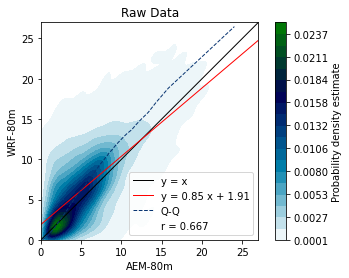

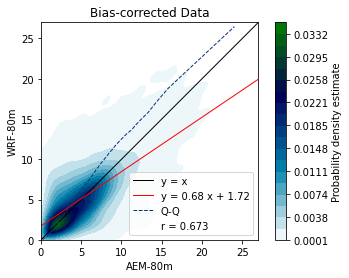

In [15]:
scat = gusi_utils.scatters(AEM_80m,WRF_80m,plotdir,title,'contour1','ocean_r')